In [1]:
import sys 
sys.path.append('..')
import alpenglow.files as af
import matplotlib.pyplot as plt
%matplotlib inline
import skimage.external.tifffile as tiff
from skimage import transform
from skimage import img_as_int
import numpy as np
import shutil as sh
import os
import boto3
from scipy import optimize
import alpenglow.stitching as ast
from imp import reload
from alpenglow.stitching import stitch, find_shift, apply_shift

In [2]:
from skimage.feature import register_translation
from skimage import img_as_float
from skimage import exposure
from skimage.io import imread_collection, ImageCollection
from skimage.external.tifffile import imread
import skimage.external.tifffile as tif
import skimage
import dask.array as da
from dask import delayed
import glob as globby

In [3]:
import configparser
import os.path as op
import cottoncandy as cc
from io import BytesIO
import tempfile

In [5]:
# cleaning up data/AO folder
rm -rf *.tif

NameError: name 'pwd' is not defined

In [4]:
s3 = boto3.resource('s3')
bucket = s3.Bucket('alpenglowoptics')
ll = list(bucket.objects.all())

In [5]:
import numpy as np
import os
import boto3


def download_s3(remote_fname, local_fname, bucket_name="alpenglowoptics"):
    """
    Download a file from S3 to our local file-system
    """
    if not os.path.exists(local_fname):
        s3 = boto3.resource('s3')
        b = s3.Bucket(bucket_name)
        b.download_file(remote_fname, local_fname)  

In [6]:
frames = []
for item in ll:
    if item.key.startswith("45degree_76/076A/000004/"):
        frames.append(item.key)
len(frames)

2933

In [26]:
frames[-1]

'45degree_76/076A/000004/000004_12639.tif'

In [17]:
mkdir 000004

In [27]:
for file in frames:
    download_s3(file, '../data/' + file)    

In [30]:
#renaming files make all files strip_frame.tif in format 06d_06d.tif
files = globby.glob("/home/nicholasreder/alpenglow/data/45degree_76/076A/000004/*.tif")
for file in files:
    parts = file.split('_')
    notif = parts[2].split('.')
    frame = notif[0].zfill(6)
    os.rename(file, '/home/nicholasreder/alpenglow/data/45degree_76/076A/000004/000004_' + frame + '.tif')

In [36]:
len(files)

2932

### This is where I left off on 2/21

In [4]:
# creating a list of image files 
file_list = ['/phantom_2_7_2017/%06d/%06d_%05d.tif'%(s, s, i) for s in range(3) for i in range(1, 1801) ]

In [5]:
f = file_list[0]
f

'/phantom_2_7_2017/000000/000000_00001.tif'

In [6]:
files_per_strip = 1800
n_strips = 3

In [7]:
# getting our credentials
CP = configparser.ConfigParser()
CP.read_file(open(op.join(op.expanduser('~'), '.aws', 'credentials')))
CP.sections()
ak = CP.get('default', 'AWS_ACCESS_KEY_ID')
sk = CP.get('default', 'AWS_SECRET_ACCESS_KEY')

In [8]:
cci = cc.get_interface('alpenglowoptics', 
                       ACCESS_KEY=ak, 
                       SECRET_KEY=sk,
                       endpoint_url='https://s3.amazonaws.com',
                       verbose=False)

sample = af.s3_to_array(file_list[0], cci)

stack = af.read_strip_files(file_list, files_per_strip, n_strips-1, cci, sample.dtype, sample.shape)
for ss in range(n_strips-2, -1, -1):
    stack = ast.stitch_zstack(
        stack, 
        af.read_strip_files(file_list, files_per_strip, ss, cci, sample.dtype, sample.shape))


In [12]:
stack.shape

(512, 1832, 1800)

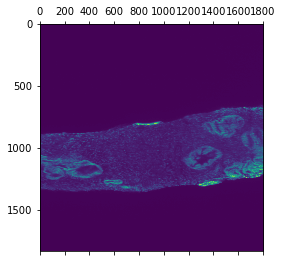

In [13]:
plt.matshow(stack[200])

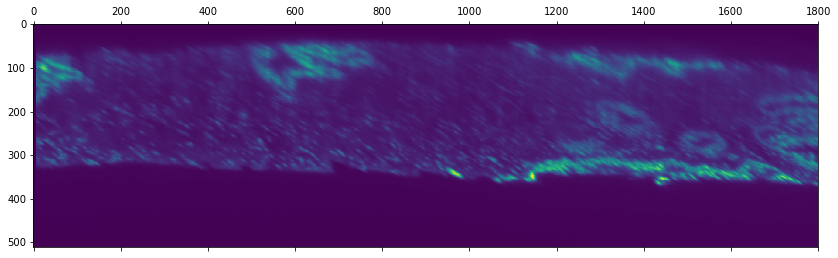

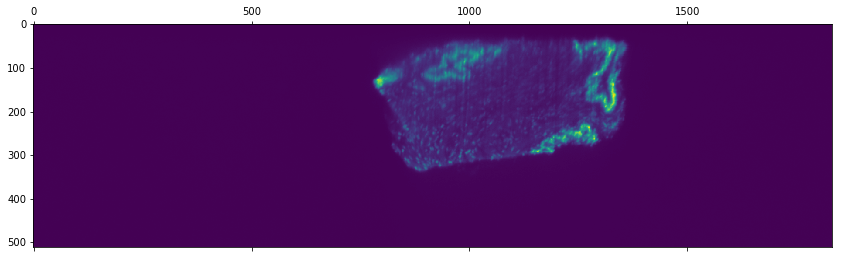

In [29]:
plt.matshow(stack[:,1000,:])
plt.matshow(stack[:,:,700])

### Implementing Ariel's volume viewer widget

In [9]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
mpl.style.use('bmh')

In [10]:
import scipy.signal as sps

In [11]:
def plot_tsnr(x=stack.shape[0]/2, y=stack.shape[1]/2, z=stack.shape[2]/2):
    fig, axes = plt.subplots(nrows=1, ncols=3)
    axes[0].set_title('Z')
    axes[0].matshow(stack[:, :, z], cmap=mpl.cm.viridis)
    axes[0].axis('off')
    axes[1].set_title('Y')
    axes[1].matshow(stack[:, y, :], cmap=mpl.cm.viridis)
    axes[1].axis('off')
    axes[2].set_title('X')
    axes[2].matshow(stack[x, :, :], cmap=mpl.cm.viridis)
    axes[2].axis('off')
    fig.set_size_inches(20, 10)
    return fig

In [12]:
import ipywidgets as wdg
import IPython.display as display

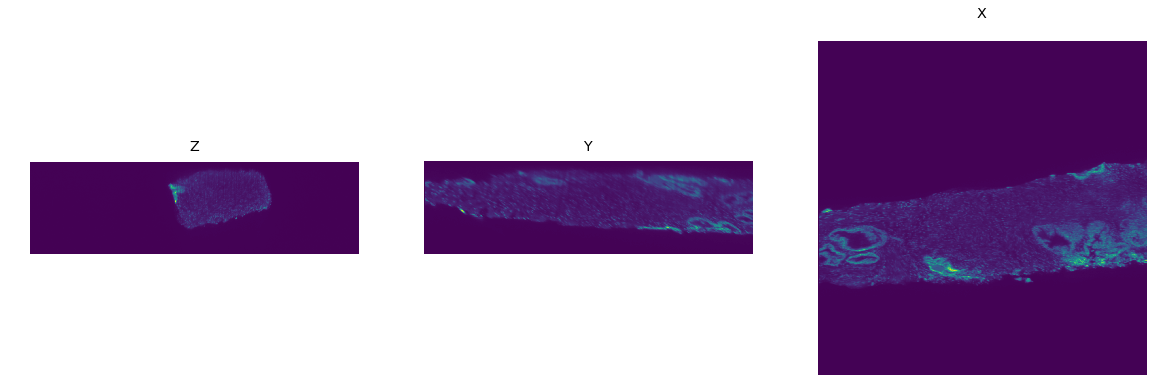

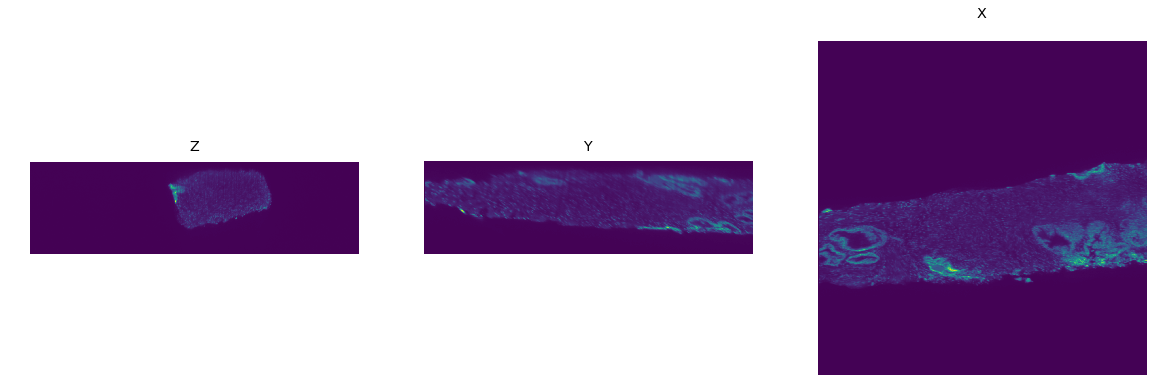

In [13]:
pb_widget = wdg.interactive(plot_tsnr, 
                            x=wdg.IntSlider(min=1, max=stack.shape[0], value=stack.shape[0]//2),
                            y=wdg.IntSlider(min=1, max=stack.shape[1], value=stack.shape[1]//2),
                            z=wdg.IntSlider(min=1, max=stack.shape[2], value=stack.shape[2]//2)
                            )
display.display(pb_widget)

In [81]:
import plotly.graph_objs as go
import plotly.plotly as py
from plotly.graph_objs import *
from plotly.widgets import GraphWidget


/opt/anaconda/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning:

The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.

/opt/anaconda/lib/python3.5/site-packages/IPython/utils/traitlets.py:5: UserWarning:

IPython.utils.traitlets has moved to a top-level traitlets package.



<IPython.core.display.Javascript object>

In [ ]:
colormap=['rgb(255,105,180)','rgb(255,255,51)','rgb(0,191,255)']
fig = FF.create_trisurf(x=stack.shape[0],
                        y=stack.shape[1], 
                        z=stack.shape[2], 
                        plot_edges=False,
                        colormap=colormap,
                        simplices=simplices,
                        title="Isosurface")
py.iplot(fig)

### Uploading files back to S3

In [22]:
z_sample = stack[200]

In [23]:
from io import BytesIO

In [ ]:
def array_to_S3(f, cci):
    """ 
    Read an array to a tif file stored on an S3 bucket (provided as a cottoncandy 
    interface)
   
    Parameters
    ----------
    f : str
        The name of the file in the bucket
    
    cci : cottoncandy interface
    
    
    """
    o = cci.upload_object(f)
    b = BytesIO(o)
    t = tif.TiffFile(b)
    a = t.asarray()
    return a

In [26]:
b = BytesIO(z_sample)
t = tif.TiffFile(b)
o = cci.upload_object("z_sample_uploadtoS3", t)

ValueError: not a valid TIFF file

In [ ]:
a = t.asarray()